# ANFIS for Viscosity Prediction

This notebook demonstrates the implementation of an Adaptive Neuro-Fuzzy Inference System (ANFIS) to predict viscosity based on temperature and pressure.

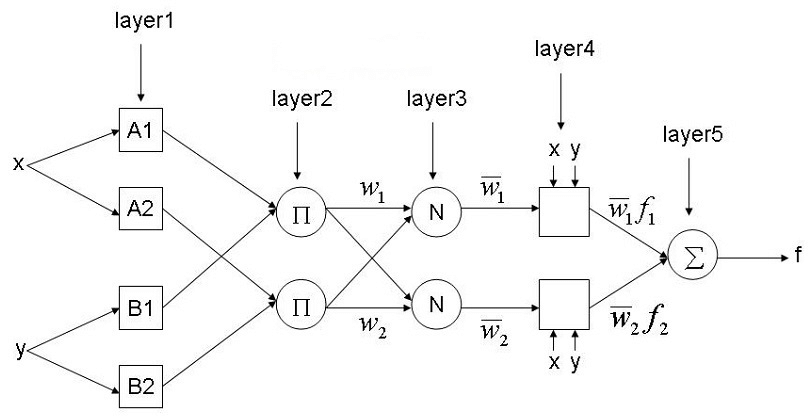

<a id="import"></a>
# <p style="background-color:#c4d9cf; font-family:calibri; font-size:75%; color:black; text-align:center; border-radius:40px 50px; padding:10px">Step 1: Import Libraries</p>


In [21]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

<a id="import"></a>
# <p style="background-color:#c4d9cf; font-family:calibri; font-size:75%; color:black; text-align:center; border-radius:40px 50px; padding:10px">Step 2: Read Dataset</p>


In [2]:
# Example dataset
data = np.array([
    [50, 1.0, 120],
    [60, 1.2, 125],
    [70, 1.5, 130],
    [80, 1.7, 135],
    [90, 2.0, 140],
])
T = data[:, 0]  # Temperature
P = data[:, 1]  # Pressure
V = data[:, 2]  # Viscosity

<a id="import"></a>
# <p style="background-color:#c4d9cf; font-family:calibri; font-size:75%; color:black; text-align:center; border-radius:40px 50px; padding:10px">Step 3: Clustering for Initial Membership Functions </p>


We use the KMeans algorithm to cluster the temperature (T) and pressure (P) values into two groups, which will form the centers of our Gaussian membership functions.

In [8]:
def initialize_membership_functions(data, num_clusters=2):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(data.reshape(-1, 1))
    centers = np.sort(kmeans.cluster_centers_.flatten())
    sigma = (centers[1] - centers[0]) / 2
    return centers, sigma

c_T, sigma_T = initialize_membership_functions(T)  # For Temperature
c_P, sigma_P = initialize_membership_functions(P)  # For Pressure

print(f'data = {data}\n')
print(f'c_T (center Temperature) = {c_T}\nsigma_T (standard deviation Temperature) = {sigma_T}\n')
print(f'c_P (center Pressure) = {c_P}\nsigma_P (standard deviation Pressure) = {sigma_P}\n')

data = [[ 50.    1.  120. ]
 [ 60.    1.2 125. ]
 [ 70.    1.5 130. ]
 [ 80.    1.7 135. ]
 [ 90.    2.  140. ]]

c_T (center Temperature) = [60. 85.]
sigma_T (standard deviation Temperature) = 12.5

c_P (center Pressure) = [1.23333333 1.85      ]
sigma_P (standard deviation Pressure) = 0.30833333333333335



<a id="import"></a>
# <p style="background-color:#c4d9cf; font-family:calibri; font-size:75%; color:black; text-align:center; border-radius:40px 50px; padding:10px">Step 4: Gaussian Membership Function</p>


For each data point, we calculate the degree of membership using a Gaussian function, which is centered around the calculated cluster centers.

```math
\mu(x) = e^{-\frac{(x - c)^2}{2\sigma^2}}
```
where:
- c: center of the membership function
- σ: width of the membership function


In [9]:
def gaussian_membership(x, c, sigma):
    return np.exp(-((x - c) ** 2) / (2 * sigma ** 2))

<a id="import"></a>
# <p style="background-color:#c4d9cf; font-family:calibri; font-size:75%; color:black; text-align:center; border-radius:40px 50px; padding:10px">Step 5: Rule Firing Strength (Layar 1 and Layar 2)</p>


The rule firing strength is computed based on the degree of membership for both temperature and pressure. For each combination of membership values, we compute a firing strength.
```math
w_i = \mu_{T}(T) \times \mu_{P}(P)
```


In [ ]:

def firing_strength(T, P, c_T, sigma_T, c_P, sigma_P):
    ''' Layar 1 '''
    
    T_low = gaussian_membership(T, c_T[0], sigma_T)
    T_high = gaussian_membership(T, c_T[1], sigma_T)
    P_low = gaussian_membership(P, c_P[0], sigma_P)
    P_high = gaussian_membership(P, c_P[1], sigma_P)

    ''' Layar 2 ''' 

    rules = [
        T_low * P_low,   #A1
        T_low * P_high,  #A2
        T_high * P_low,  #B1
        T_high * P_high, #B2
    ]

    return np.array(rules).T  # Shape: (n_samples, n_rules)

rules = firing_strength(T, P, c_T, sigma_T, c_P, sigma_P)
rules

array([[5.45342962e-01, 1.62468878e-02, 1.49007997e-02, 4.43925453e-04],
       [9.94173360e-01, 1.08385615e-01, 1.34546733e-01, 1.46683980e-02],
       [4.99575962e-01, 3.81262987e-01, 3.34875782e-01, 2.55568223e-01],
       [8.84461331e-02, 2.47008001e-01, 2.93651503e-01, 8.20095444e-01],
       [2.55090387e-03, 4.98700553e-02, 4.19487131e-02, 8.20095444e-01]])

<a id="import"></a>
# <p style="background-color:#c4d9cf; font-family:calibri; font-size:75%; color:black; text-align:center; border-radius:40px 50px; padding:10px">Step 6:Normalization Layer (Layar 3)</p>


In [ ]:
normalized_rules = rules / rules.sum(axis=1, keepdims=True)
print(f'sum = {rules.sum(axis=1, keepdims=True)}')
normalized_rules  #  5.45342962e-01/0.57693457=9.45242295e-01

sum = [[0.57693457]
 [1.25177411]
 [1.47128295]
 [1.44920108]
 [0.91446512]]


array([[9.45242295e-01, 2.81607110e-02, 2.58275381e-02, 7.69455450e-04],
       [7.94211475e-01, 8.65856027e-02, 1.07484835e-01, 1.17180871e-02],
       [3.39551247e-01, 2.59136413e-01, 2.27608008e-01, 1.73704332e-01],
       [6.10309599e-02, 1.70444257e-01, 2.02629923e-01, 5.65894861e-01],
       [2.78950375e-03, 5.45346721e-02, 4.58724038e-02, 8.96803420e-01]])

<a id="import"></a>
# <p style="background-color:#c4d9cf; font-family:calibri; font-size:75%; color:black; text-align:center; border-radius:40px 50px; padding:10px">Step 7: Linear Regression for p, q, r initialization</p>

Linear regression is used to initialize the parameters for the fuzzy rules. This allows the system to start with an estimate of the parameters before optimizing them.

In [14]:
X = np.hstack([normalized_rules * T[:, None], normalized_rules * P[:, None], normalized_rules])
y = V

lin_reg = LinearRegression().fit(X, y)
params_initial = lin_reg.coef_
params_initial

array([ 0.49970805,  0.49908506,  0.49946246,  0.49939364,  0.01053287,
        0.00995446,  0.00958937,  0.01354151, -0.02223074,  0.00904252,
        0.01016573,  0.00302249])

<a id="import"></a>
# <p style="background-color:#c4d9cf; font-family:calibri; font-size:75%; color:black; text-align:center; border-radius:40px 50px; padding:10px">Step 8: Hybrid optimization(Layar 4 and Layar 5 )</p>

In [17]:
def anfis_predict(params, T, P, rules):
    n_rules = rules.shape[1]  # Number of rules
    p = params[:n_rules]
    q = params[n_rules:2 * n_rules]
    r = params[2 * n_rules:3 * n_rules]
    '''Layar 4'''
    # Compute rule outputs
    rule_outputs = p * T[:, None] + q * P[:, None] + r
    '''Layar 5'''
    # Weighted normalization of rule outputs
    normalized_outputs = (rules * rule_outputs).sum(axis=1) / rules.sum(axis=1)

    return normalized_outputs

def loss_function(params):
    predictions = anfis_predict(params, T, P, rules)
    return np.mean((V - predictions) ** 2)

result = minimize(loss_function, x0=np.hstack([params_initial, np.zeros(4)]), method='L-BFGS-B')
params_optimized = result.x


<a id="import"></a>
# <p style="background-color:#c4d9cf; font-family:calibri; font-size:75%; color:black; text-align:center; border-radius:40px 50px; padding:10px">Step 9: Predict with optimized parameters</p>


In [16]:
predictions = anfis_predict(params_optimized, T, P, rules)
print("Actual Viscosity: ", V)
print("Predicted Viscosity: ", predictions)

Actual Viscosity:  [120. 125. 130. 135. 140.]
Predicted Viscosity:  [120.00000249 124.99999696 129.99999997 135.00000124 139.9999989 ]


In [22]:
def predict_new(T_new, P_new):
    # Step 1: Compute rule firing strengths for the new inputs
    T_low = gaussian_membership(T_new, c_T[0], sigma_T)
    T_high = gaussian_membership(T_new, c_T[1], sigma_T)
    P_low = gaussian_membership(P_new, c_P[0], sigma_P)
    P_high = gaussian_membership(P_new, c_P[1], sigma_P)

    rules_new = np.array([
        T_low * P_low,
        T_low * P_high,
        T_high * P_low,
        T_high * P_high,
    ])

    # Normalize rule strengths
    rules_new /= rules_new.sum()

    # Extract parameters
    n_rules = len(rules_new)
    p = params_optimized[:n_rules]
    q = params_optimized[n_rules:2 * n_rules]
    r = params_optimized[2 * n_rules:3 * n_rules]

    # Compute rule outputs
    rule_outputs = p * T_new + q * P_new + r

    # Aggregate weighted outputs
    predicted_viscosity = np.dot(rules_new, rule_outputs)

    return predicted_viscosity

print("Data: ", data)
print("Actual Viscosity: ", V)
print("Predicted Viscosity: ", predictions)
print('mse',mean_squared_error(V,predictions))
# Example usage for new temperature and pressure
T_new = 75
P_new = 1.6
predicted_V_new = predict_new(T_new, P_new)
print(f"Predicted Viscosity for T={T_new}, P={P_new}: {predicted_V_new}")

Data:  [[ 50.    1.  120. ]
 [ 60.    1.2 125. ]
 [ 70.    1.5 130. ]
 [ 80.    1.7 135. ]
 [ 90.    2.  140. ]]
Actual Viscosity:  [120. 125. 130. 135. 140.]
Predicted Viscosity:  [120.00000249 124.99999696 129.99999997 135.00000124 139.9999989 ]
mse 3.6358275911182307e-12
Predicted Viscosity for T=75, P=1.6: 132.6636266670469
